# Explaining a model

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import time

from pyAgrum.lib.bn2graph import BN2dot
import numpy as np
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as expl

import matplotlib.pyplot as plt

## Building the model

We build a simple graph for the example

In [2]:
template=gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv"

#gum.generateSample(template,1000,data_path)

learner = gum.BNLearner(data_path,template)
bn = learner.learnParameters(template.dag())
bn

(pyAgrum.BayesNet<double>@0x56375160d770) BN{nodes: 7, arcs: 9, domainSize: 320, dim: 37, mem: 496o}

## 1-independence list (w.r.t. the class Y)
Given a model, it may be interesting to investigate the conditional independences of the class Y created by this very model.

{('R', 'X0', ('X1', 'Z')): 0.7083382647903902,
 ('R', 'X1', ('X2', 'Z')): 0.46938486254099493,
 ('R', 'X3', ('X1', 'Z')): 0.4128522974536623,
 ('R', 'Y', ('X2', 'Z')): 0.8684231094674686,
 ('X0', 'X1', ()): 0.723302358657366,
 ('X0', 'X2', ()): 0.9801394906304377,
 ('X0', 'X3', ()): 0.7676868597218647,
 ('X0', 'Y', ('X1', 'Z')): 0.5816487109659612,
 ('X1', 'X3', ()): 0.5216508257424717,
 ('X2', 'X3', ()): 0.9837021981131505,
 ('X2', 'Z', ('X1',)): 0.6638491605436834,
 ('X3', 'Y', ('X1', 'Z')): 0.8774081450472304}

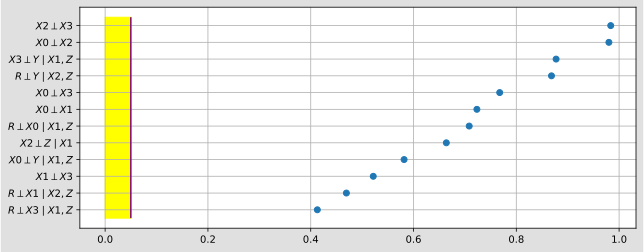

In [3]:
# this function explores all the CI between 2 variables and computes the p-values w.r.t to a csv file.
expl.independenceListForPairs(bn,data_path)

... with respect to a specific target.

{('Y', 'R', ('X2', 'Z')): 0.8684231094674686,
 ('Y', 'X0', ('X1', 'Z')): 0.5816487109659612,
 ('Y', 'X3', ('X1', 'Z')): 0.8774081450472304}

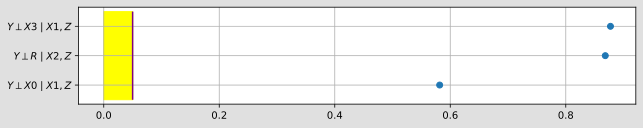

In [4]:
expl.independenceListForPairs(bn,data_path,target="Y")

## 2-ShapValues

In [5]:
print(expl.ShapValues.__doc__)


  The ShapValue class implements the calculation of Shap values in Bayesian networks.

  The main implementation is based on Conditional Shap values [3]_, but the Interventional calculation method proposed in [2]_ is also present. In addition, a new causal method, based on [1]_, is implemented which is well suited for Bayesian networks.

.. [1] Heskes, T., Sijben, E., Bucur, I., & Claassen, T. (2020). Causal Shapley Values: Exploiting Causal Knowledge. 34th Conference on Neural Information Processing Systems. Vancouver, Canada.

.. [2] Janzing, D., Minorics, L., & Blöbaum, P. (2019). Feature relevance quantification in explainable AI: A causality problem. arXiv: Machine Learning. Retrieved 6 24, 2021, from https://arxiv.org/abs/1910.13413

.. [3] Lundberg, S. M., & Su-In, L. (2017). A Unified Approach to Interpreting Model. 31st Conference on Neural Information Processing Systems. Long Beach, CA, USA.
  


The ShapValue class implements the calculation of Shap values in Bayesian networks. It is necessary to specify a target and to provide a Bayesian network whose parameters are known and will be used later in the different calculation methods.

In [6]:
gumshap = expl.ShapValues(bn, 'Y')

### Compute Conditionnal in Bayesian Network

A dataset (as a `pandas.dataframe`) must be provided so that the Bayesian network can learn its parameters and then predict.

The method `conditional` computes the conditonal shap values using the Bayesian Networks. It returns 2 graphs and a dictionary. The first one shows the distribution of the shap values for each of the variables, the second one classifies the variables by their importance.

In [7]:
train = pd.read_csv(data_path).sample(frac=1.)

Run Time : 6.555020332336426 sec


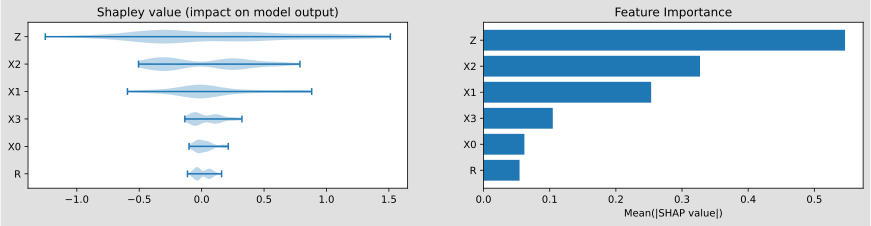

In [8]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

Run Time : 6.533151388168335 sec


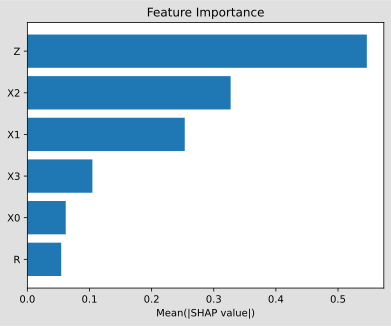

In [9]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

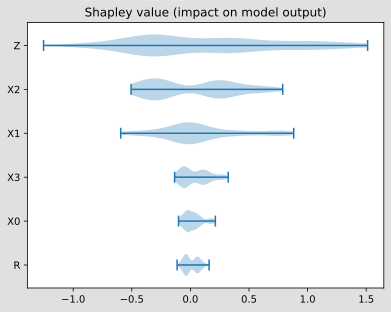

In [10]:
resultat = gumshap.conditional(train, plot=True,plot_importance=False,percentage=False)

The result is returned as a dictionary, the keys are the names of the features and the associated value is the absolute value of the average of the calculated shap.

In [11]:
t_start = time.time()
resultat = gumshap.conditional(train, plot=False,plot_importance=False,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
resultat

Run Time : 6.702162027359009 sec


{'X3': 0.10465402104047894,
 'Z': 0.5464180054433384,
 'X2': 0.3271606443752006,
 'R': 0.054456334441524,
 'X1': 0.2533375405370652,
 'X0': 0.06176712200000176}

### Causal Shap Values

This method is similar to the previous one, except the formula of computation. It computes the causal shap value as described in the paper of Heskes *Causal Shapley Values: Exploiting Causal Knowledge
to Explain Individual Predictions of Complex Models* .

Run Time : 7.7997331619262695 sec


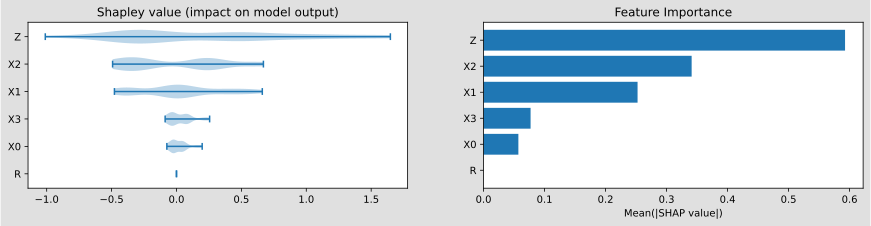

In [12]:
t_start = time.time()
causal = gumshap.causal(train, plot=True, plot_importance=True, percentage=False)
print(f'Run Time : {time.time()-t_start} sec')

As you can see, since $R$ is not among the 'causes' of Y, its causal importance is null.

### Marginal Shap Values

Similarly, one can also compute marginal Shap Value.

Run Time : 28.884862661361694 sec
{'X3': 0.0, 'Z': 0.7024075022383361, 'X2': 0.3373915852958653, 'R': 0.0, 'X1': 0.3257494551946588, 'X0': 0.0}


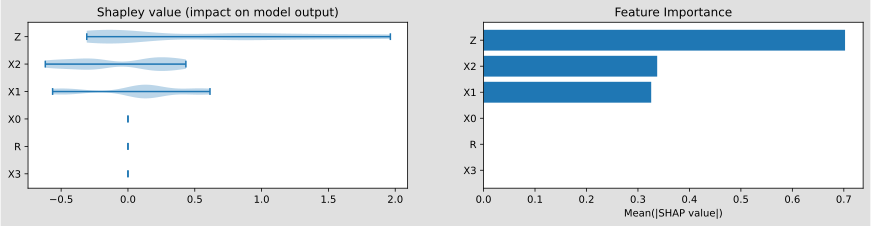

In [13]:
t_start = time.time()
marginal = gumshap.marginal(train, sample_size=10, plot=True,plot_importance=True,percentage=False)
print(f'Run Time : {time.time()-t_start} sec')
print(marginal)

As you can see, since $R$, $X0$ and $X3$ are no in the Markov Blanket of $Y$, their marginal importances are null.

### Visualizing shapvalues directly on a BN

This method returns a coloured graph that makes it easier to understand which variable is important and where it is located in the graph.

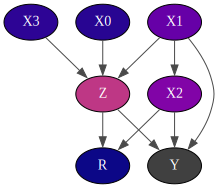

In [14]:
import pyAgrum.lib.notebook as gnb

g = gumshap.showShapValues(causal)
gnb.showGraph(g)

## 2- Visualizing information

Another type of informations comes from then Information Theory : 

In [15]:
ie=gum.LazyPropagation(bn)
ie.addJointTarget({"X1","Z"})
gnb.sideBySide(ie.posterior("Z"),ie.posterior("X1"),ie.jointPosterior({"X1","Z"}),
              captions=["$P(Z)$","$P(X1)$","$P(X1,Z)$"])

info=gum.InformationTheory(ie,"Z","X1")
print(f'Entropy(Z) = {info.entropyX()}')
print(f'MutualInformation(Z,X1) = {info.mutualInformationXY()}')

Entropy(Z) = 0.9760595867385566
MutualInformation(Z,X1) = 0.08460612407416464


`ShowInformation` allows to show these informations directly in the graph :

In [16]:
expl.showInformation(bn)

## 3- Visualizing nested Markov blanket

In a Bayesian network, the (minimal) Markov blanket of node A includes its parents, children and the other parents of all of its children.
Nested Markov blanket proposes to structure the visualization of the graph by specifyin a node A and by builing the successive markov blankets of higher order (a Markov Blanket of order n+1 is the union of the (minimal) Markov blankets of the node of the Markov blanket of order n).

In [17]:
bn=gum.loadBN("res/alarm.dsl")
gnb.flow.row(bn,expl.nestedMarkovBlankets(bn,"VENTALV",1),expl.nestedMarkovBlankets(bn,"VENTALV",2),
               captions=["Bayesian network 'alarm'","Markov Blanket for node VENTALV","Markov Blanket of order 2 for node VENTALV"])

These nested Markov blanket allow us to define a "MB-distance" for each node connected to the target. The MB-distance of a node from the target is the order of the nested Markov blanket which contains this node.

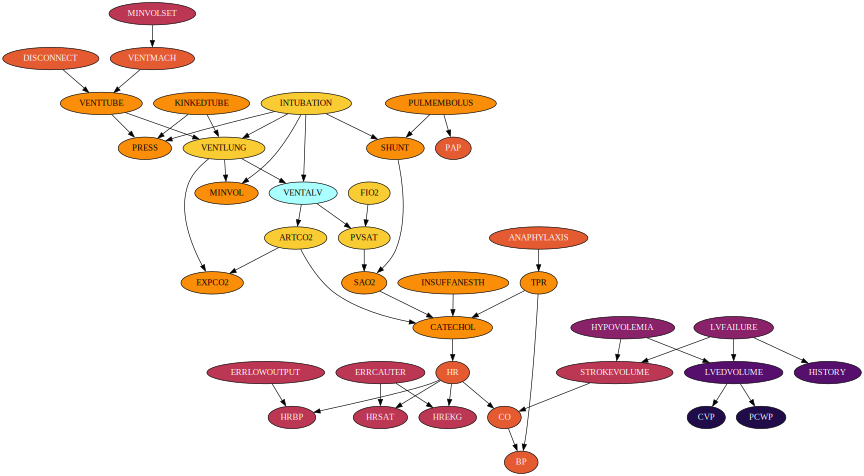

In [18]:
# show all the nodes connected to VENTALV w.r.t to the MB-distance
gnb.showGraph(expl.nestedMarkovBlankets(bn,"VENTALV",-1),size='12!')

In [19]:
# the MB-distance for the nodes:
expl.nestedMarkovBlanketsNames(bn,"VENTALV",-1)

{'KINKEDTUBE': 2,
 'HYPOVOLEMIA': 5,
 'INTUBATION': 1,
 'MINVOLSET': 4,
 'PULMEMBOLUS': 2,
 'INSUFFANESTH': 2,
 'ERRLOWOUTPUT': 4,
 'ERRCAUTER': 4,
 'FIO2': 1,
 'LVFAILURE': 5,
 'DISCONNECT': 3,
 'ANAPHYLAXIS': 3,
 'PAP': 3,
 'STROKEVOLUME': 4,
 'TPR': 2,
 'LVEDVOLUME': 6,
 'VENTMACH': 3,
 'PCWP': 7,
 'SHUNT': 2,
 'HISTORY': 6,
 'VENTTUBE': 2,
 'CVP': 7,
 'VENTLUNG': 1,
 'MINVOL': 2,
 'PRESS': 2,
 'VENTALV': 0,
 'ARTCO2': 1,
 'PVSAT': 1,
 'SAO2': 2,
 'EXPCO2': 2,
 'CATECHOL': 2,
 'HR': 3,
 'HRBP': 4,
 'HRSAT': 4,
 'CO': 3,
 'HREKG': 4,
 'BP': 3}